# Attempting to measure the effectiveness of volatility indexs
<p style='width:100%'>
This notebook will look at how to quantify the overall effectiveness of a calculated index. 
<br/>To do this, the index will be measured for a random set of points in time. As these indexes are forward looking, for a given point in time the 52 week performance of each index will be measured started at the select point in time.
These performance measures will then be aggregated. 
<br/>The metrics taken can be found in metrics_calc.py, and examples of each will be provided in the Metrics_Overview Notebook.
<p>

In [23]:
%load_ext autoreload
%autoreload 2

import metrics_calc
from vix_calc_class import vix_calc
from vix_alternative import vix_alternative
import random

import sqlite3
import pandas as pd
pd.set_option('display.precision', 2)

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Aggregate Metrics
<p style='width=60%'>
This Section will employ the metrics we developed in Metrics_Overview over a random sample of dates.

<by/>These metrics will be calculated using the metrics_calc.py program, and a consistent random seed will be used.

<br/> The two main metrics of interest here are Bound Accuracy and the Curve Areas    

**Bound Accuracy**: 
    Measures how frequently the absolute change of the stocks price exceeds the expected volatilty bounds as prescribed by the VIX. Because these volatiltiy indexes are meant to represent a 1 standard deviation, we should expect 64.2% of points to fall within the index. Meaning that for a given index, the closer its accuracy is the 0.642 or 64.2% the better it is.

**Curve Areas**: 
    Attempts to measure how closely an index forecasted the real volatility over the following years. The is done by taking the difference between the area of the curve as set out by our volatility index, and the area under the curve as set out by the real relative change in the stock over a 52 week period. An ideal index will be closer to 0.
</p>


## Measure Classic VIX

Here a random sample of 100 points will be taken. it should be noted that due to data contraints not all points will be calculated, these points will be removed from analysis.
For each point of time, the specified volatility index will be calculated, metrics will then be taken for the indexes following 52 week performance. These metrics will then be aggregated for interpretation. 

In [50]:
num_weeks=100
V = vix_calc()
metric_data, all_data = metrics_calc.run_aggs(vix_method=V, num_weeks=num_weeks, userandom=True)

mm = pd.DataFrame.from_dict(metric_data)
mm = mm.dropna()
mm.head(5)

,date,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,yearchange,vixtotal,RMSE,MAPE
0,2020-09-18,25.52,0.38,36.32,43.14,-197.88,330.65,441.40,33.49,895.62,5.68,0.48
1,2016-12-02,12.99,0.32,10.71,13.17,-78.60,219.68,264.46,20.38,455.77,2.41,0.18
2,2020-04-24,35.04,0.53,36.44,101.51,-116.40,282.97,416.74,47.27,1229.59,5.12,1.77
3,2018-07-13,12.06,0.94,12.75,247.38,-10.49,279.59,300.65,7.53,423.02,5.74,6.43
4,2019-08-09,17.53,0.85,22.04,273.17,-18.08,291.62,334.57,14.73,615.15,7.07,3.02


#### Performance Matrix
The following matrix provides a snapshot of the indexes aggregate performance.
It should be noted that of the 100 select dates 89 were successfully evaluated.

printed under the matrix are a few select measures including
- Mean Accuracy
- Mean Area Between Curves
- Mean Ratio:
    This metric Referes to the mean ratio between the area between curves over the total area of the volatilty curve. 

In [51]:
metrics_calc.aggregate_metrics.curve_areas(mm)
mm['change_type'] = mm.yearchange.apply(lambda x: 'positive' if x>0 else 'negative')

display(mm[["vix", 'accuracy', 'stddev', 'vixtotal', 'auc', 'aoc', 'abc', 'rd', "RMSE", "MAPE"]].describe())

print(f"Mean Accuracy: {mm.accuracy.mean()}")

print(f"\nMean Area Under Curve: {mm.auc.mean()}")
print(f"Mean Area Over Curve: {mm.aoc.mean()}")
print(f"Mean Area Between Curves: {(mm.abc).mean()}")
print(f'Ratio : {mm.rd.mean()}')

,vix,accuracy,stddev,vixtotal,auc,aoc,abc,rd,RMSE,MAPE
count,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00
mean,17.99,0.73,18.58,630.54,226.91,-48.41,178.50,0.28,6.21,6.28
std,9.02,0.24,9.67,316.03,190.43,66.93,235.22,0.32,3.24,17.19
min,8.73,0.08,6.69,306.35,5.48,-362.39,-356.91,-0.42,1.64,0.10
25%,12.31,0.58,10.71,431.83,96.53,-64.54,-7.93,-0.01,3.68,0.89
50%,15.56,0.77,14.31,545.99,180.94,-22.00,139.57,0.30,5.63,3.02
75%,20.61,0.94,25.30,723.09,311.66,-2.70,309.99,0.56,7.68,5.38
max,65.19,1.00,40.13,2287.61,887.83,0.00,887.83,0.80,18.88,155.34


Mean Accuracy: 0.7339078651685392

Mean Area Under Curve: 226.90723538591985
Mean Area Over Curve: -48.41157218958334
Mean Area Between Curves: 178.49566319633652
Ratio : 0.27592040835477183


In [30]:
mm.MAPE.describe()

count       89.00
mean       627.63
std       1719.27
min         10.06
25%         89.35
50%        302.14
75%        538.20
max      15533.96
Name: MAPE, dtype: float64

#### Year change graph
The following graph observes the relationhsip between the volatility index and the following 52 week change in stockprice.

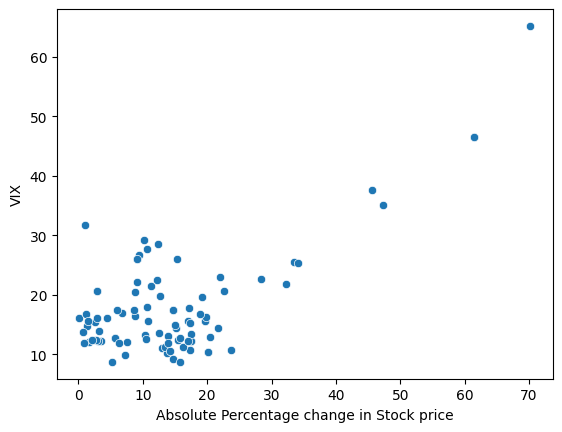

In [19]:
mm['abs_change'] = abs(mm.yearchange)

g = sns.scatterplot(data=mm, x='abs_change', y='vix');
g.set_ylabel("VIX")
g.set_xlabel("Absolute Percentage change in Stock price")
g.figure.savefig("figures/yearchange1.png")

### Measure Alternative VIX

Here a again random sample of 100 points will be taken. it should be noted that due to data contraints not all points will be calculated, these points will be removed from analysis.
For each point of time, the specified volatility index will be calculated, metrics will then be taken for the indexes following 52 week performance. These metrics will then be aggregated for interpretation. 

In [52]:
num_weeks=100
Va = vix_alternative()
metric_data, all_data = metrics_calc.run_aggs(vix_method = Va, num_weeks = num_weeks, userandom=True)

mm['change_type'] = mm.yearchange.apply(lambda x: 'positive' if x>0 else 'negative')

mm = pd.DataFrame.from_dict(metric_data)
mm = mm.dropna()
mm.head(3)

,date,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,yearchange,vixtotal,RMSE,MAPE
0,2020-09-18,36.72,0.96,36.32,239.79,-1.64,330.65,441.40,33.49,1288.52,5.33,0.76
1,2016-12-02,20.74,0.98,10.71,206.79,-0.24,219.68,264.46,20.38,727.74,4.22,0.52
2,2020-04-24,48.65,1.00,36.44,462.60,0.00,282.97,416.74,47.27,1707.08,9.44,2.67


#### Performance Matrix
The following matrix provides a snapshot of the indexes aggregate performance.
It should be noted that of the 100 select dates 89 were successfully evaluated.

printed under the matrix are a few select measures including
- Mean Accuracy
- Mean Area Between Curves
- Mean Ratio:
    This metric Referes to the mean ratio between the area between curves over the total area of the volatilty curve. 

In [55]:
metrics_calc.aggregate_metrics.curve_areas(mm)
mm['change_type'] = mm.yearchange.apply(lambda x: 'positive' if x>0 else 'negative')
mm['abs_change'] = abs(mm.yearchange)

display(mm[['accuracy', 'stddev', 'vixtotal', 'auc', 'aoc', 'abc', 'rd', "RMSE", "MAPE"]].describe())

print(f"Mean Accuracy: {mm.accuracy.mean()}")

print(f"\nMean Area Under Curve: {mm.auc.mean()}")
print(f"Mean Area Over Curve: {mm.aoc.mean()}")
print(f"Mean Area Between Curves: {(mm.abc).mean()}")
print(f'Ratio : {mm.rd.mean()}')

,accuracy,stddev,vixtotal,auc,aoc,abc,rd,RMSE,MAPE
count,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00,89.00
mean,0.97,18.58,972.85,526.25,-5.45,520.80,0.53,11.13,10.22
std,0.06,9.67,465.46,328.39,12.29,332.95,0.22,6.58,25.83
min,0.70,6.69,472.56,81.96,-77.56,51.58,0.11,2.74,0.21
25%,0.94,10.71,689.77,315.93,-5.75,296.78,0.38,6.67,1.72
50%,1.00,14.31,829.26,457.37,0.00,457.37,0.55,9.43,5.02
75%,1.00,25.30,1117.10,630.15,0.00,629.42,0.72,13.87,9.28
max,1.00,40.13,3289.77,1837.46,0.00,1837.46,0.91,37.72,231.33


Mean Accuracy: 0.9650179775280899

Mean Area Under Curve: 526.2531492090218
Mean Area Over Curve: -5.449757336634778
Mean Area Between Curves: 520.803391872387
Ratio : 0.5265176069082447


#### Year change graph
The following graph observes the relationhsip between the volatility index and the following 52 week change in stockprice.

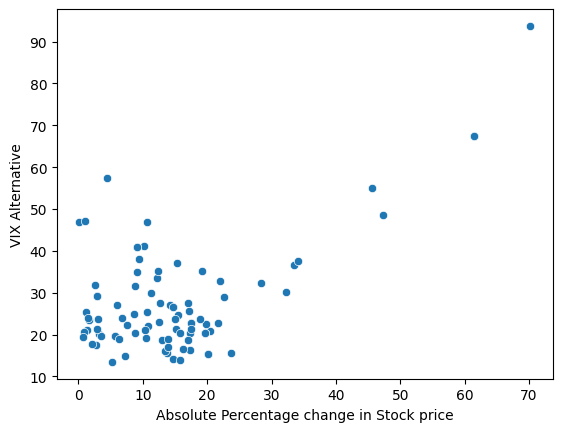

In [22]:
# g = sns.jointplot(data=mm, x='yearchange', y='vix', height=4.5, ratio=7, hue='change_type');
mm['abs_change'] = abs(mm.yearchange)

g = sns.scatterplot(data=mm, x='abs_change', y='vix');
g.set_ylabel("VIX Alternative")
g.set_xlabel("Absolute Percentage change in Stock price")
g.figure.savefig("figures/yearchange2.png")